✅ 1. Feature Importance (일반적 중요도)
정의
모델 자체에서 계산하는 각 피처가 예측에 얼마나 기여했는지를 정량화한 값. 주로 트리 기반 모델 (XGBoost, CatBoost, LightGBM)에서 사용됨.

방식
gain: 분할 후 얻어진 정확도 향상 정도 (가장 일반적)

split: 몇 번 해당 피처가 노드에서 분할에 사용됐는가

weight, cover, total_gain 등 다양한 방식 존재

장점
계산이 빠름

모델 내부 구조 기반이므로 내장된 함수로 바로 사용 가능

피처 개수가 많아도 비교적 부담 없음

단점
상호작용(interaction) 효과를 고려하지 않음

모델이 편향되어 있으면 중요도 왜곡 가능 (예: 상관관계 높은 변수 중 하나만 높게 나옴)

🔍 실제 추천 사용 흐름
초기 스크리닝:
feature_importance로 상위 피처 50~100개 추림

정밀 분석:
추린 피처에 대해 SHAP으로 영향력 + 방향성 해석

최종 선정 및 시각화:
SHAP summary_plot, beeswarm_plot 등으로 발표·보고용 설명

In [1]:
# [1] 모듈 로딩
import pandas as pd
import seaborn as sns
import koreanize_matplotlib
import matplotlib.pyplot as plt
import numpy as np

import ipywidgets

In [2]:
# ✅ 예측 대상 설정
target_cols = ["D_배수지_유출유량2", "D_배수지_수위7_m3", "D_배수지_수위8_m3"]

In [3]:
# [2] 데이터 로딩

## 데이터 불러오기
DATA_D = "./result/features.csv"
DF = pd.read_csv(DATA_D, encoding='utf-8-sig', parse_dates=['시각'])  # parse_dates : 열을 바로 datetime으로 변환

In [4]:
## 원래 컬럼명만 추출
#base_columns = [col.split('.')[0] for col in A_DF.columns]

## 처음 등장한 컬럼만 유지
#_, idx = np.unique(base_columns, return_index=True)

## 인덱스로 유일 컬럼만 선택
#A_DF = A_DF.iloc[:, sorted(idx)]

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ✅ 입력 피처: 타겟 컬럼 제외한 나머지 전체
features = [col for col in DF.columns if col not in target_cols]

# ✅ 입력/출력 분리
X = DF[features]
y = DF[target_cols].dropna()

# ✅ 시계열 기반 분할 (train:val:test = 70:15:15)
n = len(y)
train_size = int(n * 0.7)
val_size = int(n * 0.15)
test_size = n - train_size - val_size

X_train = X.iloc[:train_size]
y_train = y.iloc[:train_size]
X_val = X.iloc[train_size:train_size + val_size]
y_val = y.iloc[train_size:train_size + val_size]
X_test = X.iloc[train_size + val_size:]
y_test = y.iloc[train_size + val_size:]

# ✅ CatBoost 모델 설정 + MultiOutput 래핑
base_model = CatBoostRegressor(
    iterations=500,
    depth=6,
    learning_rate=0.05,
    loss_function='RMSE',
    verbose=100
)
model = MultiOutputRegressor(base_model)
model.fit(X_train, y_train)

# ✅ 테스트셋 예측
y_pred = model.predict(X_test)

# ✅ 타겟별 성능 평가
for i, col in enumerate(target_cols):
    print(f"\n[예측 성능] {col}")
    rmse = np.sqrt(mean_squared_error(y_test[col], y_pred[:, i]))
    mae = mean_absolute_error(y_test[col], y_pred[:, i])
    r2 = r2_score(y_test[col], y_pred[:, i])

    print(f"RMSE: {rmse:.4f}")
    print(f"MAE : {mae:.4f}")
    print(f"R²  : {r2:.4f}")

0:	learn: 14.4869209	total: 163ms	remaining: 1m 21s
100:	learn: 0.5387740	total: 2.15s	remaining: 8.5s
200:	learn: 0.3599444	total: 3.98s	remaining: 5.91s
300:	learn: 0.3067663	total: 5.75s	remaining: 3.8s
400:	learn: 0.2746012	total: 7.51s	remaining: 1.85s
499:	learn: 0.2508262	total: 9.34s	remaining: 0us
0:	learn: 561.6079529	total: 18.8ms	remaining: 9.36s
100:	learn: 16.3554492	total: 2s	remaining: 7.89s
200:	learn: 10.6566375	total: 4.19s	remaining: 6.23s
300:	learn: 8.6902387	total: 6.38s	remaining: 4.22s
400:	learn: 7.4958284	total: 8.65s	remaining: 2.14s
499:	learn: 6.7398172	total: 10.8s	remaining: 0us
0:	learn: 568.5114275	total: 21.7ms	remaining: 10.8s
100:	learn: 17.4585878	total: 2.2s	remaining: 8.71s
200:	learn: 11.7229682	total: 4.49s	remaining: 6.67s
300:	learn: 9.2118377	total: 7.09s	remaining: 4.69s
400:	learn: 7.8372274	total: 9.31s	remaining: 2.3s
499:	learn: 6.9226076	total: 11.3s	remaining: 0us

[예측 성능] D_배수지_유출유량2
RMSE: 0.3023
MAE : 0.1927
R²  : 0.9995

[예측 성능] D_

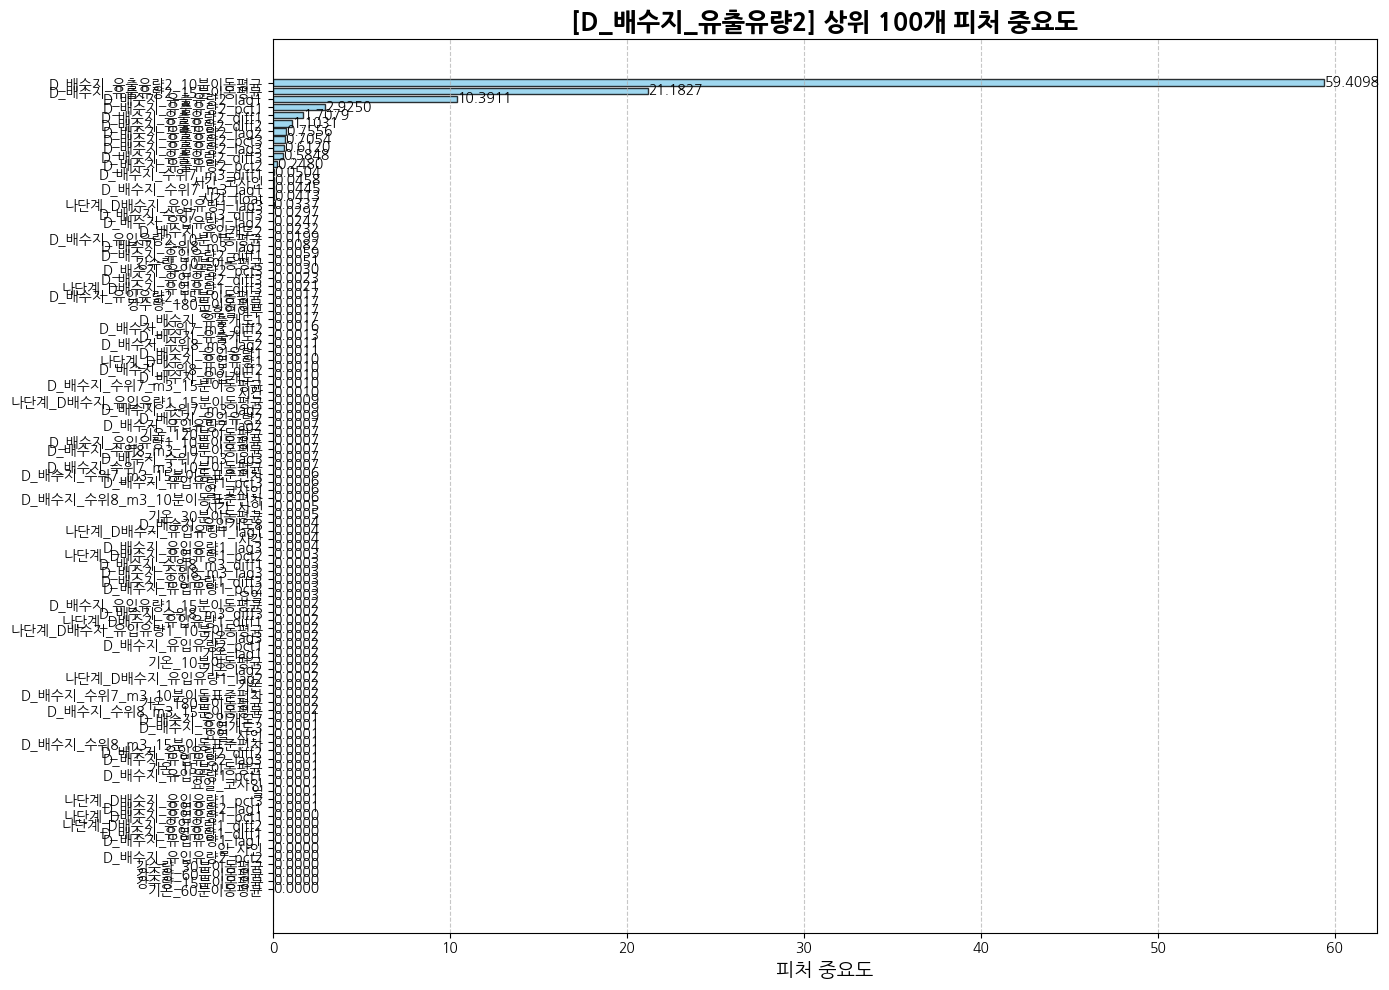


[D_배수지_유출유량2] 상위 100개 중요한 피처:
 1. D_배수지_유출유량2_10분이동평균
 2. D_배수지_유출유량2_15분이동평균
 3. D_배수지_유출유량2_lag1
 4. D_배수지_유출유량2_pct1
 5. D_배수지_유출유량2_diff1
 6. D_배수지_유출유량2_diff2
 7. D_배수지_유출유량2_lag2
 8. D_배수지_유출유량2_pct3
 9. D_배수지_유출유량2_lag3
10. D_배수지_유출유량2_diff3
11. D_배수지_유출유량2_pct2
12. D_배수지_수위7_m3_diff1
13. 시간_코사인
14. D_배수지_수위7_m3_lag1
15. 시간_float
16. 나단계_D배수지_유입유량1_lag3
17. D_배수지_수위7_m3_diff3
18. D_배수지_유입유량1_lag2
19. D_배수지_유입개도2
20. D_배수지_유입유량2_10분이동평균
21. D_배수지_수위8_m3_lag1
22. D_배수지_유입유량2_diff1
23. 강수량_10분이동평균
24. D_배수지_유입유량2_pct3
25. D_배수지_유입유량2_diff3
26. 나단계_D배수지_유입유량1_diff3
27. D_배수지_유입유량2_15분이동평균
28. 강수량_180분이동평균
29. 공휴일여부
30. D_배수지_유출개도1
31. D_배수지_수위7_m3_diff2
32. D_배수지_유출개도2
33. D_배수지_수위8_m3_lag2
34. D_배수지_유입유량1
35. 나단계_D배수지_유입유량1
36. D_배수지_수위8_m3_diff2
37. D_배수지_유입개도1
38. D_배수지_수위7_m3_15분이동평균
39. 시간
40. 나단계_D배수지_유입유량1_15분이동평균
41. D_배수지_수위7_m3_lag2
42. D_배수지_유입유량2
43. D_배수지_유입유량2_lag2
44. 기온_120분이동평균
45. D_배수지_유입유량1_10분이동평균
46. D_배수지_수위8_m3_10분이동평균
47. D_배수지_수위7_m3_lag3
48. D_배수지_수위7_m3_

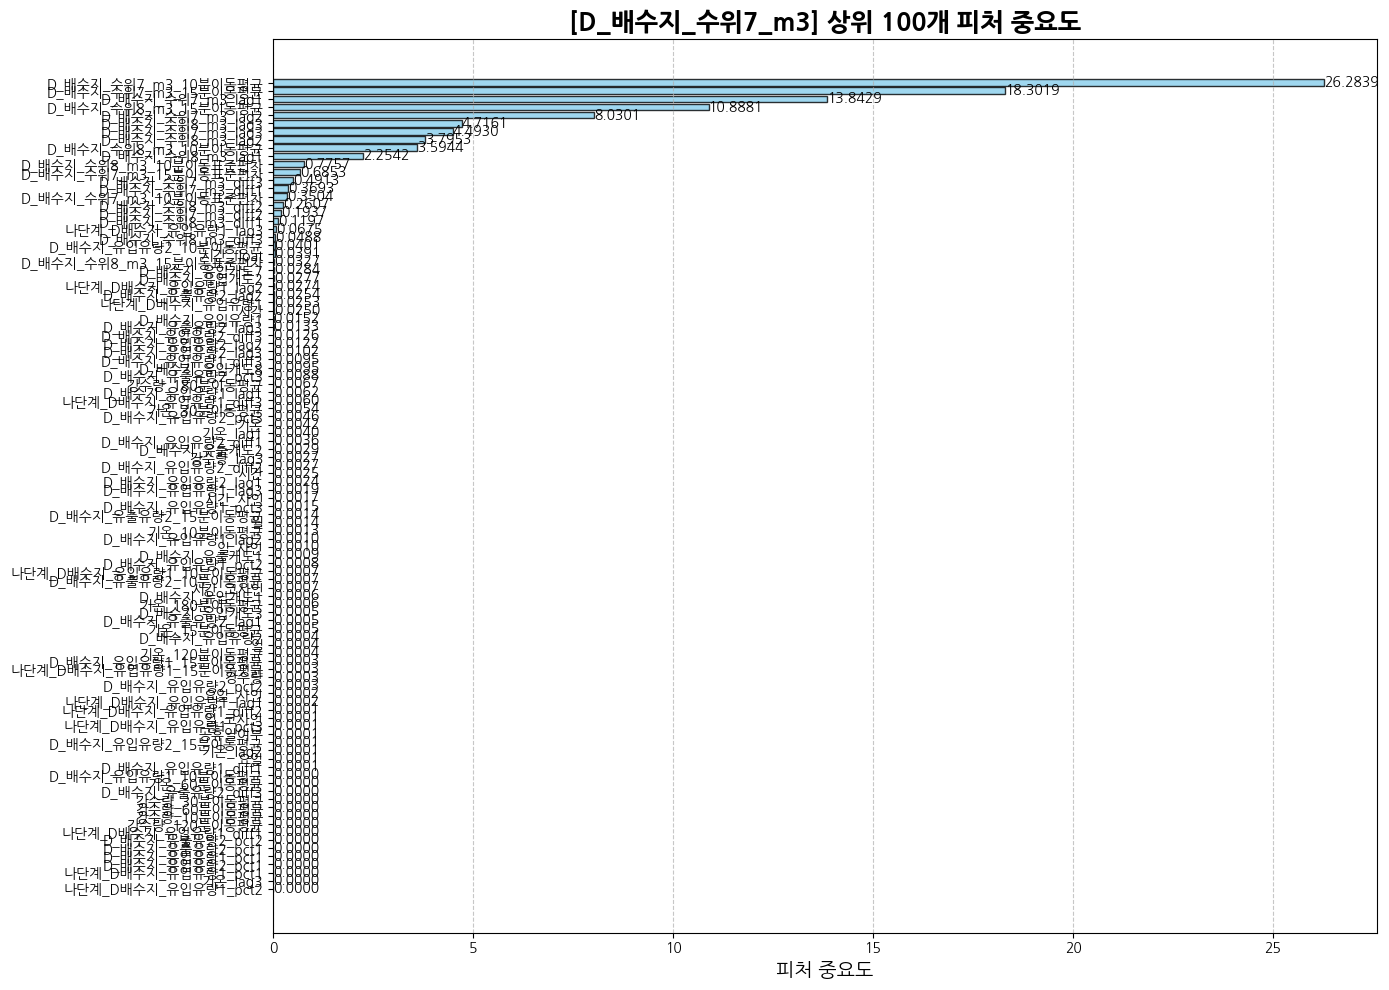


[D_배수지_수위7_m3] 상위 100개 중요한 피처:
 1. D_배수지_수위7_m3_10분이동평균
 2. D_배수지_수위7_m3_15분이동평균
 3. D_배수지_수위7_m3_lag1
 4. D_배수지_수위8_m3_15분이동평균
 5. D_배수지_수위7_m3_lag2
 6. D_배수지_수위8_m3_lag3
 7. D_배수지_수위7_m3_lag3
 8. D_배수지_수위8_m3_lag2
 9. D_배수지_수위8_m3_10분이동평균
10. D_배수지_수위8_m3_lag1
11. D_배수지_수위8_m3_10분이동표준편차
12. D_배수지_수위7_m3_15분이동표준편차
13. D_배수지_수위7_m3_diff3
14. D_배수지_수위7_m3_diff1
15. D_배수지_수위7_m3_10분이동표준편차
16. D_배수지_수위8_m3_diff2
17. D_배수지_수위7_m3_diff2
18. D_배수지_수위8_m3_diff1
19. 나단계_D배수지_유입유량1_lag3
20. D_배수지_수위8_m3_diff3
21. D_배수지_유입유량2_10분이동평균
22. 시간_float
23. D_배수지_수위8_m3_15분이동표준편차
24. D_배수지_유입개도7
25. D_배수지_유입개도2
26. 나단계_D배수지_유입유량1_lag2
27. D_배수지_유출유량2_lag2
28. 나단계_D배수지_유입유량1
29. 시각
30. D_배수지_유입유량1
31. D_배수지_유출유량2_lag3
32. D_배수지_유입유량2_diff3
33. D_배수지_유입유량2_lag2
34. D_배수지_유입유량2_lag3
35. D_배수지_유입유량1_diff3
36. D_배수지_유입개도8
37. D_배수지_유출유량2_pct3
38. 강수량_180분이동평균
39. D_배수지_유입유량1_lag1
40. 나단계_D배수지_유입유량1_diff3
41. 기온_30분이동평균
42. D_배수지_유입유량2_pct3
43. 기온
44. 기온_lag1
45. D_배수지_유입유량2_diff1
46. D_배수지_유출개도2
47. 강수량_la

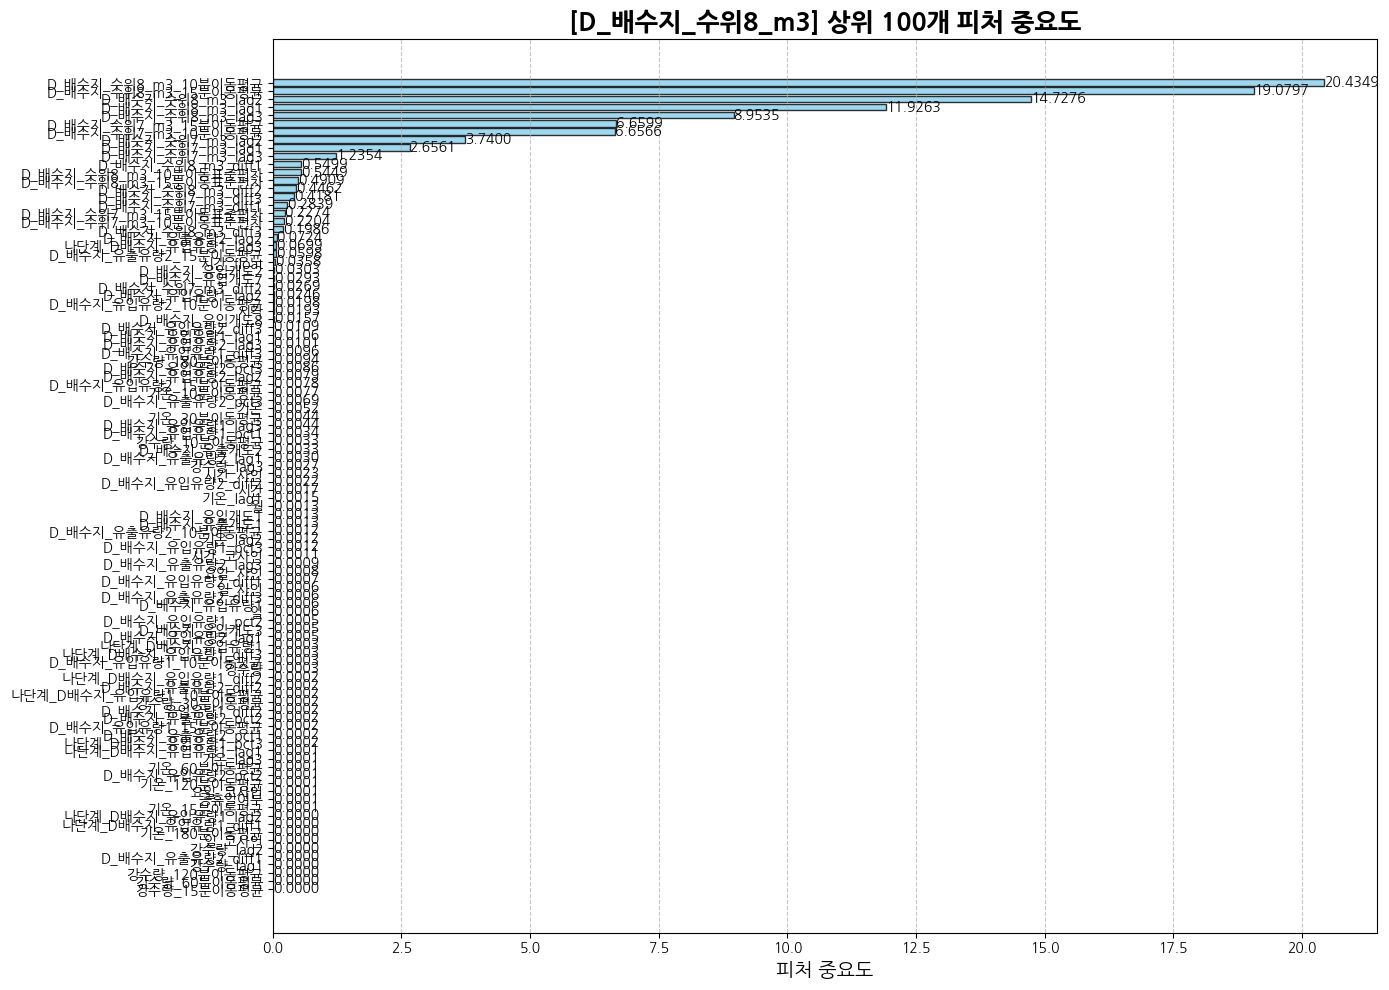


[D_배수지_수위8_m3] 상위 100개 중요한 피처:
 1. D_배수지_수위8_m3_10분이동평균
 2. D_배수지_수위8_m3_15분이동평균
 3. D_배수지_수위8_m3_lag2
 4. D_배수지_수위8_m3_lag1
 5. D_배수지_수위8_m3_lag3
 6. D_배수지_수위7_m3_15분이동평균
 7. D_배수지_수위7_m3_10분이동평균
 8. D_배수지_수위7_m3_lag2
 9. D_배수지_수위7_m3_lag1
10. D_배수지_수위7_m3_lag3
11. D_배수지_수위8_m3_diff1
12. D_배수지_수위8_m3_10분이동표준편차
13. D_배수지_수위8_m3_15분이동표준편차
14. D_배수지_수위8_m3_diff2
15. D_배수지_수위7_m3_diff3
16. D_배수지_수위7_m3_diff1
17. D_배수지_수위7_m3_15분이동표준편차
18. D_배수지_수위7_m3_10분이동표준편차
19. D_배수지_수위8_m3_diff3
20. D_배수지_유출유량2_lag2
21. 나단계_D배수지_유입유량1_lag3
22. D_배수지_유출유량2_15분이동평균
23. 시간_float
24. D_배수지_유입개도2
25. D_배수지_유입개도7
26. D_배수지_수위7_m3_diff2
27. D_배수지_유입유량1_lag2
28. D_배수지_유입유량2_10분이동평균
29. 시각
30. D_배수지_유입개도8
31. D_배수지_유입유량2_diff3
32. D_배수지_유입유량1_lag1
33. D_배수지_유입유량2_lag3
34. D_배수지_유입유량1_diff3
35. 강수량_180분이동평균
36. D_배수지_유입유량2_pct3
37. D_배수지_유입유량2_lag2
38. D_배수지_유입유량2_15분이동평균
39. 기온_10분이동평균
40. D_배수지_유출유량2_pct3
41. 기온
42. 기온_30분이동평균
43. D_배수지_유입유량1_lag3
44. D_배수지_유입유량1_pct1
45. 강수량_10분이동평균
46. D_배수지_유출개도2
47. D_배

In [7]:
# ✅ 각 타겟별 피처 중요도 시각화 + 저장
top_features_dict = {}  # 타겟별 상위 피처 저장용 딕셔너리

for i, col in enumerate(target_cols):
    importances = model.estimators_[i].get_feature_importance()
    sorted_idx = np.argsort(importances)[::-1][:100]
    top_features = [X.columns[j] for j in sorted_idx]
    top_values = importances[sorted_idx]

    # 시각화
    plt.figure(figsize=(14, 10))
    plt.barh(top_features[::-1], top_values[::-1], color='skyblue', edgecolor='black', alpha=0.8)
    plt.xlabel("피처 중요도", fontsize=14)
    plt.title(f"[{col}] 상위 100개 피처 중요도", fontsize=18, fontweight='bold')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    for idx, val in enumerate(top_values[::-1]):
        plt.text(val, idx, f'{val:.4f}', va='center', fontsize=10)
    plt.tight_layout()
    plt.show()

    # 출력
    print(f"\n[{col}] 상위 100개 중요한 피처:")
    for j, fname in enumerate(top_features, 1):
        print(f"{j:2d}. {fname}")

    # 저장
    top_features_dict[col] = top_features

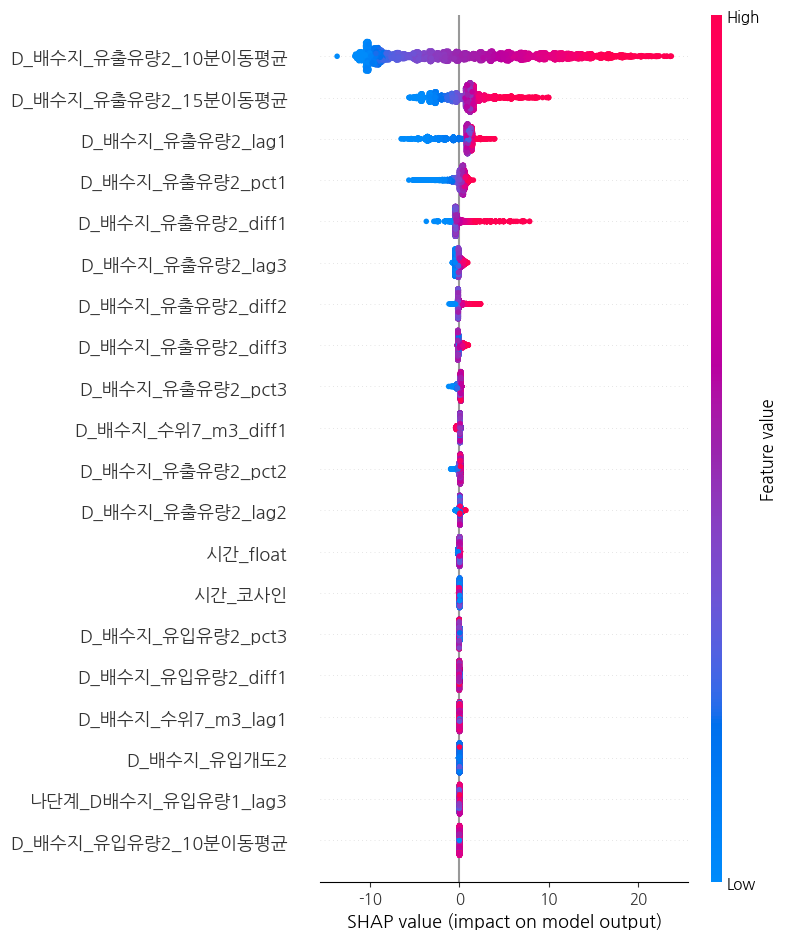


✅ [D_배수지_유출유량2] SHAP 분석 완료



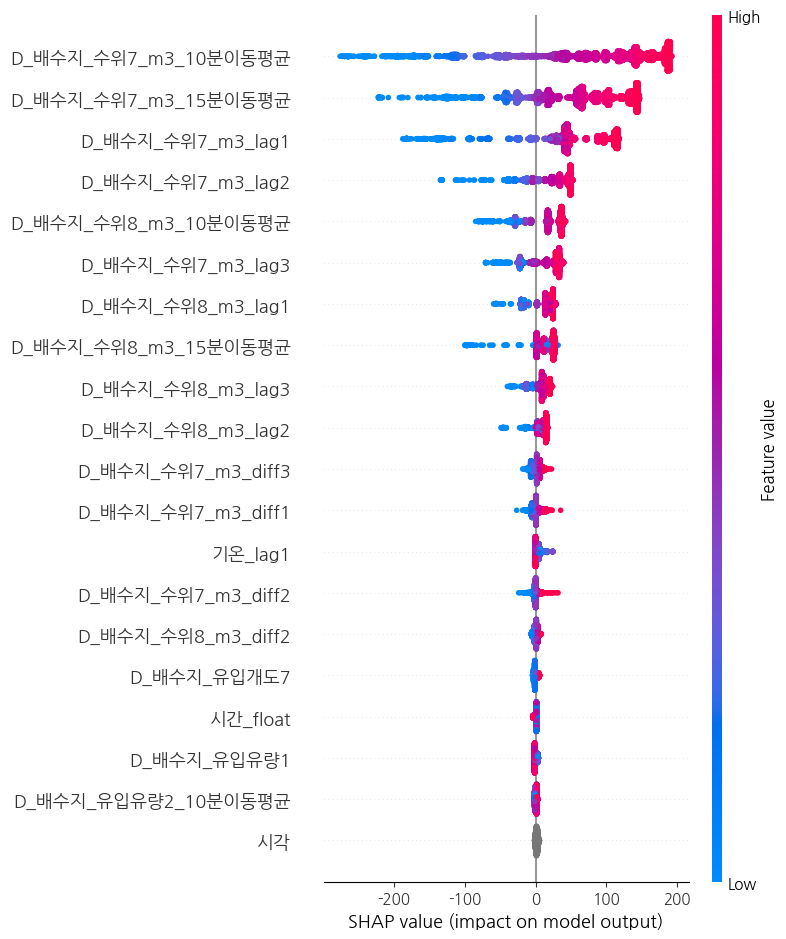


✅ [D_배수지_수위7_m3] SHAP 분석 완료



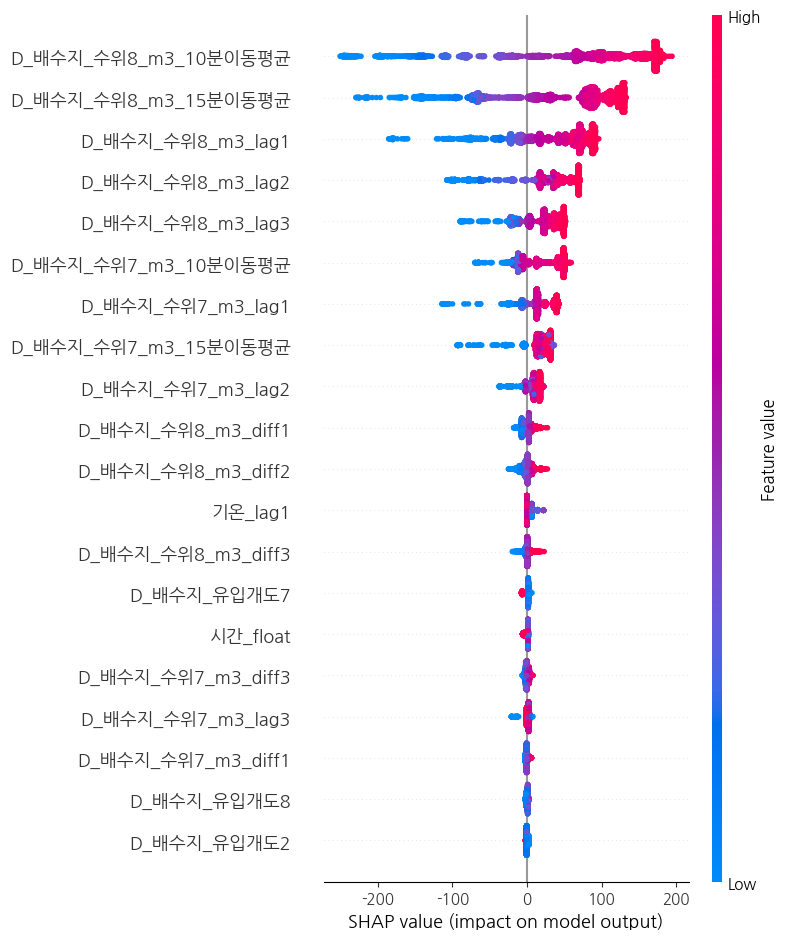


✅ [D_배수지_수위8_m3] SHAP 분석 완료



In [8]:
import shap

# 개별 모델 접근
for i, col in enumerate(target_cols):
    explainer = shap.TreeExplainer(model.estimators_[i])
    shap_values = explainer.shap_values(X_test)

    # 상위 20개 중요 피처 기준 summary_plot
    shap.summary_plot(shap_values, X_test, max_display=20)
    print(f"\n✅ [{col}] SHAP 분석 완료\n")


#### 1단계: 상위 20개 피처만으로 모델 경량화 재학습

In [9]:
# 예시: 타겟별 상위 20개씩 추출 후 합집합

top_features_set = set()
for t in target_cols:
    top_features_set.update(top_features_dict[t][:20])

selected_features = list(top_features_set)


In [10]:
# ✅ 입력 및 출력 분리
X = DF[selected_features]
y = DF[target_cols].dropna()

# ✅ 시계열 분할 (train:val:test = 70:15:15)
n = len(y)
train_size = int(n * 0.7)
val_size = int(n * 0.15)
test_size = n - train_size - val_size

X_train = X.iloc[:train_size]
y_train = y.iloc[:train_size]
X_val = X.iloc[train_size:train_size + val_size]
y_val = y.iloc[train_size:train_size + val_size]
X_test = X.iloc[train_size + val_size:]
y_test = y.iloc[train_size + val_size:]

# ✅ 모델 정의 및 학습
base_model = CatBoostRegressor(
    iterations=500,
    depth=6,
    learning_rate=0.05,
    loss_function='RMSE',
    verbose=100
)
model = MultiOutputRegressor(base_model)
model.fit(X_train, y_train)

# ✅ 테스트셋 성능 평가
y_pred = model.predict(X_test)

for i, col in enumerate(target_cols):
    print(f"\n[테스트 성능] {col}")
    rmse = np.sqrt(mean_squared_error(y_test[col], y_pred[:, i]))
    mae = mean_absolute_error(y_test[col], y_pred[:, i])
    r2 = r2_score(y_test[col], y_pred[:, i])

    print(f"RMSE: {rmse:.4f}")
    print(f"MAE : {mae:.4f}")
    print(f"R²  : {r2:.4f}")

0:	learn: 14.4883306	total: 8.72ms	remaining: 4.35s
100:	learn: 0.5458983	total: 986ms	remaining: 3.89s
200:	learn: 0.3669104	total: 1.96s	remaining: 2.91s
300:	learn: 0.3129512	total: 2.88s	remaining: 1.9s
400:	learn: 0.2736521	total: 3.86s	remaining: 952ms
499:	learn: 0.2489941	total: 4.85s	remaining: 0us
0:	learn: 561.6847417	total: 10.2ms	remaining: 5.07s
100:	learn: 17.1603764	total: 1.24s	remaining: 4.91s
200:	learn: 11.2240857	total: 2.33s	remaining: 3.47s
300:	learn: 9.1294683	total: 3.44s	remaining: 2.27s
400:	learn: 7.7883813	total: 4.67s	remaining: 1.15s
499:	learn: 6.8808118	total: 5.72s	remaining: 0us
0:	learn: 568.6612781	total: 11.2ms	remaining: 5.58s
100:	learn: 16.7246897	total: 1.16s	remaining: 4.58s
200:	learn: 11.1576389	total: 2.27s	remaining: 3.37s
300:	learn: 9.0409619	total: 3.35s	remaining: 2.22s
400:	learn: 7.7452022	total: 4.45s	remaining: 1.1s
499:	learn: 6.8762569	total: 5.51s	remaining: 0us

[테스트 성능] D_배수지_유출유량2
RMSE: 0.2815
MAE : 0.1916
R²  : 0.9995

[테스트

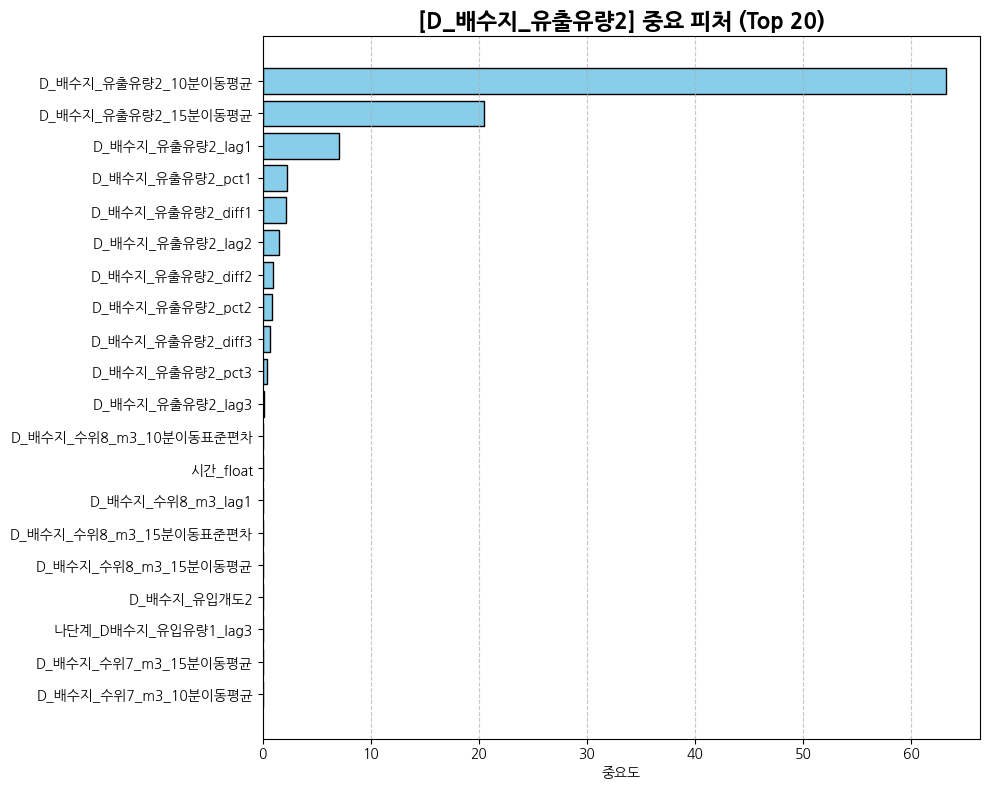

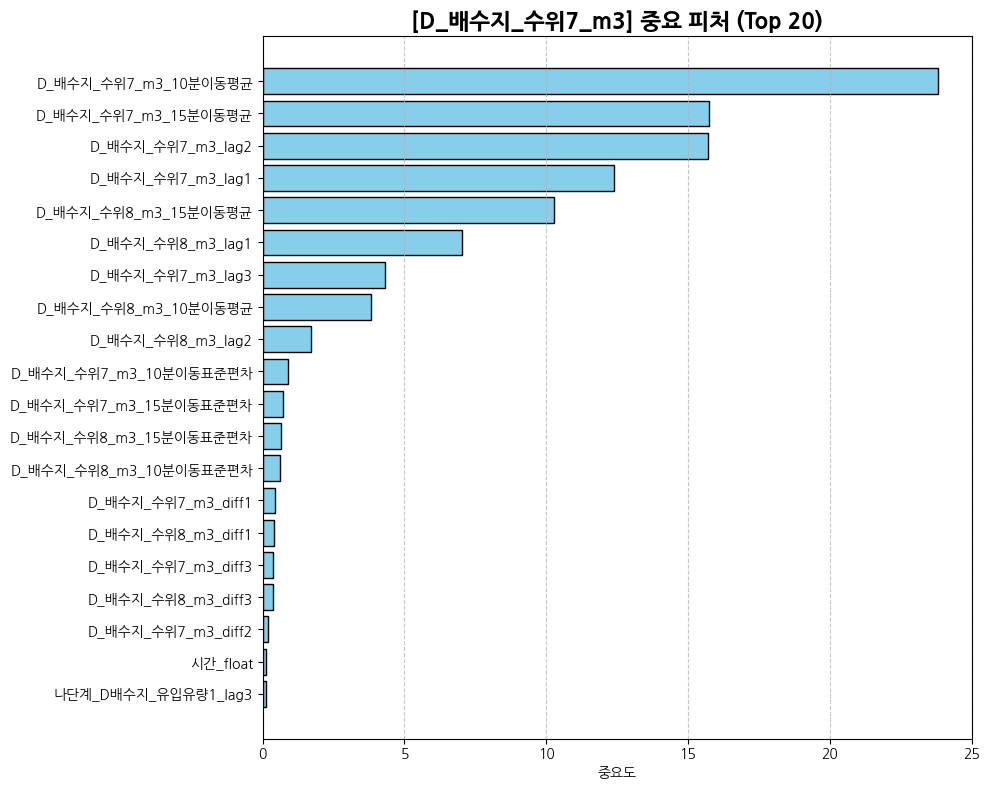

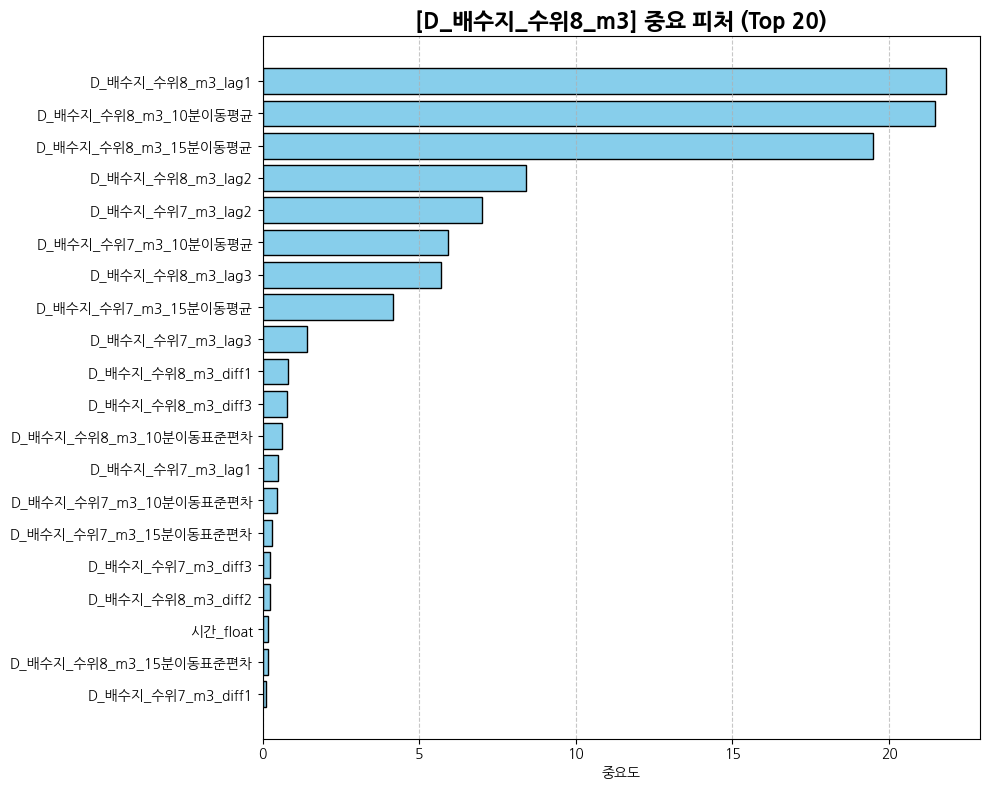

In [11]:
# ✅ 피처 중요도 시각화 (선택된 피처 기준)
for i, col in enumerate(target_cols):
    importances = model.estimators_[i].get_feature_importance()
    sorted_idx = np.argsort(importances)[::-1][:20]
    top_feats = [X.columns[j] for j in sorted_idx]
    top_vals = importances[sorted_idx]

    plt.figure(figsize=(10, 8))
    plt.barh(top_feats[::-1], top_vals[::-1], color='skyblue', edgecolor='black')
    plt.title(f"[{col}] 중요 피처 (Top 20)", fontsize=16, fontweight='bold')
    plt.xlabel("중요도")
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

In [12]:
import os
import joblib

# 저장 폴더 지정
save_dir = "./result"
os.makedirs(save_dir, exist_ok=True)

# top 20만 저장하는 버전
for target, feature_list in top_features_dict.items():
    top20 = feature_list[:20]  # 상위 20개만 추출

    shap_test_dummy = np.zeros((100, len(top20)))
    X_sub_dummy = pd.DataFrame(np.zeros((100, len(top20))), columns=top20)
    top_idx_dummy = list(range(len(top20)))

    # 저장 경로 구성
    save_path = os.path.join(save_dir, f"{target}_shap.pkl")

    joblib.dump((shap_test_dummy, X_sub_dummy, top_idx_dummy), save_path)
    print(f"✅ 저장 완료 (Top 20): {save_path}")

✅ 저장 완료 (Top 20): ./result\D_배수지_유출유량2_shap.pkl
✅ 저장 완료 (Top 20): ./result\D_배수지_수위7_m3_shap.pkl
✅ 저장 완료 (Top 20): ./result\D_배수지_수위8_m3_shap.pkl
